# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2024
## Семинар 14.09. Численное моделирование случайных величин. Графическая интерпретация результатов

Этот ноутбук представляет собой материал для семинара "Численное моделирование случайных величин". Читая его, Вы научитесь:

- Сэмплировать случайные величины из сложных распределений

- Численно проверять верность условий и заключений теорем из курса теории вероятностей и математической статистики

- визуализировать полученные результаты информативно и делать по ним выводы

- давать количественную оценку скорости сходимости и качества приближения теоретических объектов эмпирическими

Вопросы по ноутбуку и первому домашнему заданию задавайте в телеграмм автору https://t.me/vitalii_kondratiuk.

Sapere aude.

In [ ]:
# Matplotlib needed to correctly display suptitles,
# as well as some other minor things.
# I thought I might as well ensure everything is up to date
%pip install --upgrade matplotlib numpy scipy statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:
from __future__ import annotations
import typing
import abc
import dataclasses
import itertools

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns

sns.set(style='darkgrid')
%matplotlib inline

**Зафиксируем** `seed` для воспроизводимости.

In [ ]:
np.random.seed(42)

Терминология:

- Выборка: набор одинаково распределённых независимых величин из одного (как это будет в задачах, неизвестного) распределения. В рамках данного ноутбука считается, что распределение --- элемент параметрического семейства распределений.
- Теоретический: вычисленный аналитически и/или доказанный математически строго. Например, теоретическая дисперсия, сходимость в теории и т.д.
- Эмпирический: построенный/вычисленный/доказанный по выборке ("эмпирическим данным"). Например, эмпирическая дисперсия (вычисленная по выборке), сходимость доказана эмпирически (строгого результата нет, но есть наблюдения)

### Задача 1. Закон больших чисел и сходимость по вероятности.

Часто в задачах необходимо проверить наличие сходимости по вероятности последовательности величин к некоторой величине. Аналитики занимаются этим, чтобы проверить, насколько точны в пределе их методы, а математики часто проверяют наличие эмпирической сходимости перед тем, как пытаться доказывать что-то строго, чтобы не начать доказывать ложный факт. К тому же эмпирическая проверка сходимости позволяет оценить скорость сходимости на приближенной к жизни модели и понять, как поведёт себя величина на реальной задаче.

В первых двух домашках Вы будете изучать сходимости разных оценок при разных условиях. А мы начнём с простого --- закон больших чисел для распределения Бернулли. Изучим поведение статистики $\overline{X}$ --- эмпирического мат. ожидания (среднего).

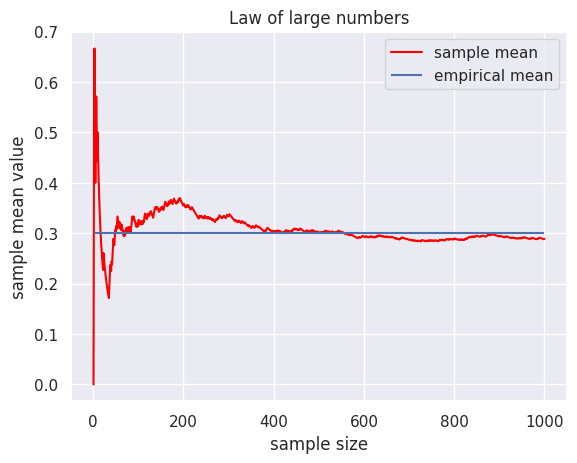

In [ ]:
N = 1000 # sample size
mu = 0.3 # expectation
X = sps.bernoulli.rvs(p=0.3, size=N)

P = np.cumsum(X)/np.arange(1, N+1)
plt.xlabel('sample size')
plt.ylabel('sample mean value')
plt.title('Law of large numbers')
plt.plot(np.arange(1, N+1), P, label='sample mean', color='red')
plt.hlines(mu, xmin=1, xmax=N, label='empirical mean')
plt.legend()

Численная оценка скорости сходимости.

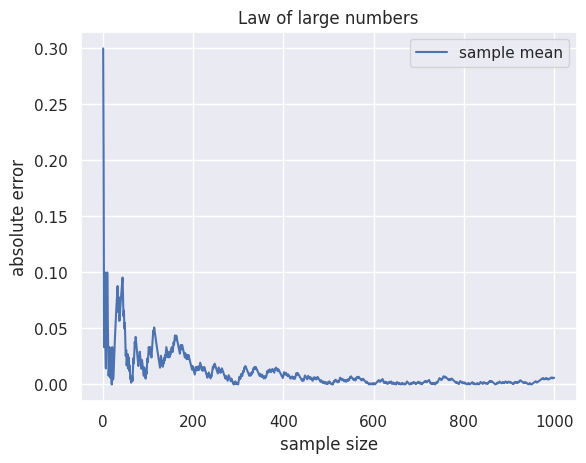

In [ ]:
N = 1000 # sample size
mu = 0.3 # expectation
X = sps.bernoulli.rvs(p=0.3, size=N)

P = abs(np.cumsum(X)/np.arange(1, N+1) - mu)
plt.xlabel('sample size')
plt.ylabel('absolute error')
plt.title('Law of large numbers')
plt.plot(np.arange(1, N+1), P, label='sample mean')
plt.legend()

In [ ]:
print(abs(X.mean() - mu))

0.006000000000000005


Абсолютная ошибка сходится к нулю. Но свидетельствует ли это о наличии сходимости по вероятности? Почему?

Определение. Последовательность $\xi_i$ сходится по вероятности к $\xi$, если $\forall \varepsilon > 0\colon \mathsf P(|\xi_n - \xi| > \varepsilon) \rightarrow 0$ с ростом $n$.

Как это проверить? Необходимо эмпирически проверить, что вероятность отклонения от предела стремится к нулю. Как это сделать? Вероятность это приближение понятия частоты и её можно эмпирически посчитать, собрав выборку $|\xi_n - \xi|$ и сравнив, как часто значение этого выражения бывает больше, чем эпсилон. В нашем случае $\xi_n$ это среднее, для подсчёта которого нужна выборка $(X_1, \ldots, X_n)$. Так мы приходим к понятию "выборка выборок". Мы просемплируем $N^2$ элементов из распределения Бернулли, по ним посчитаем $N$ средних и проверим, часто ли эти средние отклоняются от $\varepsilon$.

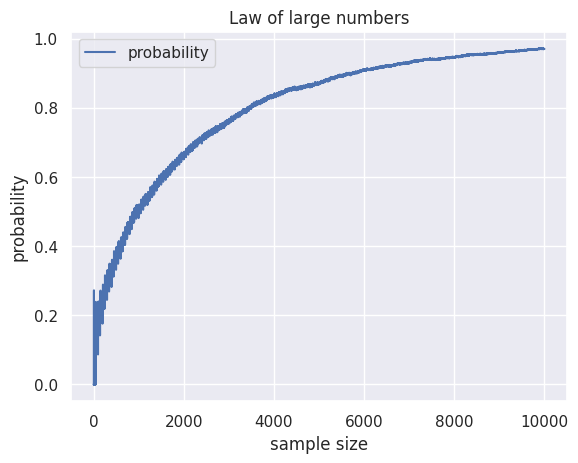

In [ ]:
eps = 1e-2
N = 10000
X = sps.bernoulli.rvs(p=0.3, size=(N,N))
P = abs(np.cumsum(X, axis=1)/np.arange(1, N+1) - mu)

prob = (P < eps).sum(axis=0)/N
plt.xlabel('sample size')
plt.ylabel('probability')
plt.title('Law of large numbers')
plt.plot(np.arange(1, N+1), prob, label='probability')
plt.legend()

Вероятность, хоть и медленно, но сходится к единице.

In [ ]:
print((P[:,-1] < eps).sum(axis=0)/N)

0.97


Считать вероятность оказывается неудобно и графики потом становятся неинформативными. Мы ничего не узнаём о том, как ведёт себя траектория сходимости величины $|\xi_n - \xi|$ в среднем. Попробуем нарисовать эти траектории, используя параметр прозрачности $\alpha$

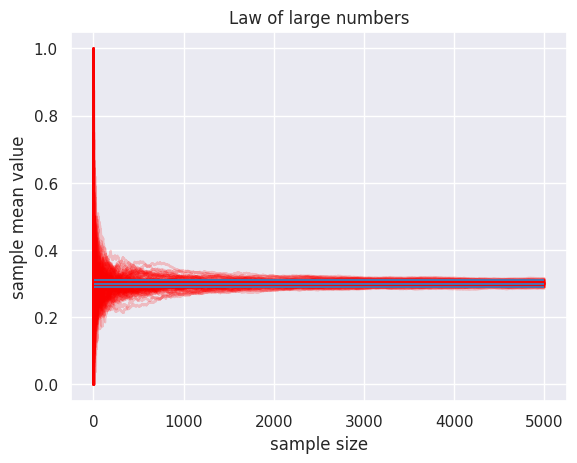

In [ ]:
N = 5000 # sample size
mu = 0.3 # expectation
eps = 1e-2
X = sps.bernoulli.rvs(p=0.3, size=(100, N))

P = np.cumsum(X, axis=1)/np.arange(1, N+1)
plt.xlabel('sample size')
plt.ylabel('sample mean value')
plt.title('Law of large numbers')
plt.plot(np.arange(1, N+1), P.T, color='red', alpha=0.2)
plt.hlines(mu, xmin=1, xmax=N)
plt.hlines(mu+eps, xmin=1, xmax=N)
plt.hlines(mu-eps, xmin=1, xmax=N)

Вот теперь можно наглядно сделать вывод о наличии сходимости по вероятности и оценить худшую и типичную скорость сходимости оценки средним.

 ### Центральная предельная теорема и сходимость по распределению.

Для практических приложений бывает полезно понять, как ведёт себя случайная величина в пределе по распределению, чтобы сэмплировать её, изучать её количественные свойства (моменты, мода, квантили) и находить эмпирические зависимости в источнике этой величины (так часто делают физики и экономисты).

Мы будем учиться проверять наличие сходимости (а заодно и равенства) по распределению на примере центральной предельной теоремы, используя то же самое распределение Бернулли. Заметим, что делать строгий вывод на основе графиков нельзя, и стоит либо доказывать её теоретически (что часто бывает слишком затруднительно), либо использовать аппарат проверки гипотез (о котором мы поговорим ближе к концу семестра)

Центральная предельная теорема говорит о сходимости величины $\sqrt{n}(\overline{X} - \mu)$ к нормальному распределению. Просемплируем выборку $\sqrt{n}(\overline{X} - \mu)$, используя уже известную технику "выборки выборок". Как известно, плотность распределения можно неплохо дискретно приблизить при помощи гистограммы.

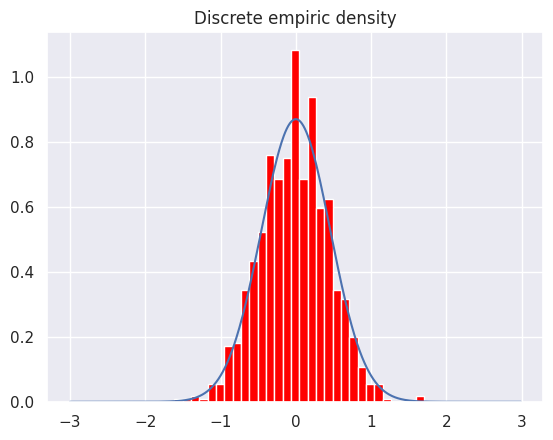

In [ ]:
N = 1000 # sample size
mu = 0.3 # expectation
sigma = np.sqrt(mu*(1 - mu)) # variance
X = sps.bernoulli.rvs(p=0.3, size=(N, N))

P = np.sqrt(N)*(np.sum(X, axis=1)/N - mu)
plt.title('Discrete empiric density')
_ = plt.hist(P.ravel(), bins=30, color='red', density=True)
grid = np.arange(-3, 3, 1e-2)
plt.plot(grid, sps.norm.pdf(grid, scale=sigma, loc=0))

Что-то о форме плотности распределения по грамотно построенной гистограмме (т.е. при правильном подборе бинов) узнать можно. Этого обычно хватает аналитикам, которые задаются простыми вопросами о среднем и концентрации величины вокруг него, но этого, конечно, не хватает статистам, которые хотят сэмплировать из предельной величины и использовать плотность для моделирования. Чего им не хватает? Не хватает им непрерывности построенной функции. Гистограмма сходится слишком медленно, её неудобно интегрировать и многое другое.

Из курса матана мы знаем, что существует более элегантное приближение функции по точкам --- свёртка. Мы можем заставить гистограмму быть более похожей на какую-то известную функцию с хорошими свойствами. Обычно берётся гауссиана.

Функция, с которой берётся свёртка называется ядром. Метод оценивания --- ядерная оценка плотности. Изучите его документацию: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html и попробуйте самостоятельно доказать наличие функциональной сходимости KDE к плотности для $C^2$ функций распределения с ростом размера выборки в качестве упражнения.

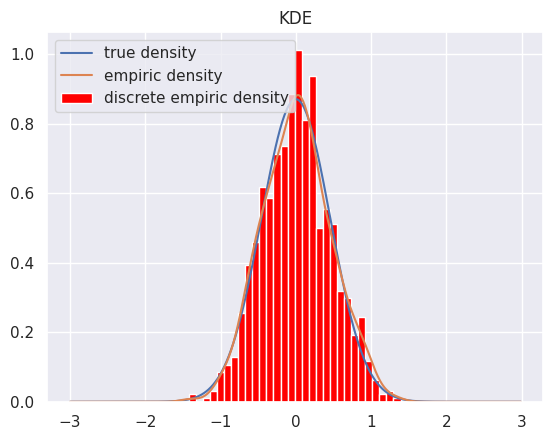

In [ ]:
plt.title('KDE')
kernel = sps.gaussian_kde(P)
grid = np.arange(-3, 3, 1e-2)
plt.plot(grid, sps.norm.pdf(grid, scale=sigma, loc=0), label='true density')
plt.plot(grid, kernel(grid), label='empiric density')
_ = plt.hist(P.ravel(), bins=30, color='red', density=True, label='discrete empiric density')
plt.legend()

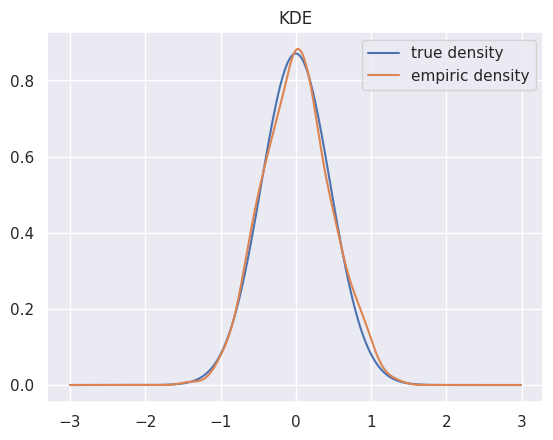

In [ ]:
plt.title('KDE')
kernel = sps.gaussian_kde(P)
grid = np.arange(-3, 3, 1e-2)
plt.plot(grid, sps.norm.pdf(grid, scale=sigma, loc=0), label='true density')
plt.plot(grid, kernel(grid), label='empiric density')
plt.legend()

Вот, теперь по KDE можно делать вывод о похожести эмпирической и теоретической плотности. Можно делать вывод и о равенстве, но только при помощи проверки гипотез (об этом позже в курсе).

У KDE есть один недостаток: по нему сложно делать вывод о хвостах распределения, так как хвосты обоих распределений стремятся к нулю, но могут делать это с разной скоростью. Отличия между распределениями Коши и нормального дают хороший пример того, как важно следить за хвостами.

Наоборот, если данные принадлежат гипотетическому правильному семейству распределений, но аналитик либо угадал неверно параметр (либо не может его угадать), то KDE сразу же об этом сообщит. Пример см. ниже, что будет если мы неверно посчитаем мат. ожидание и дисперсию предельной нормальной величины.

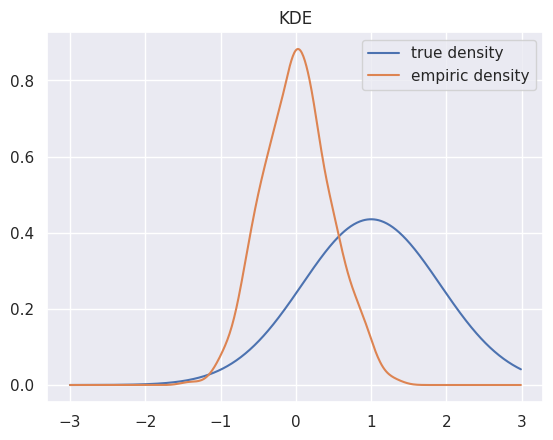

In [ ]:
plt.title('KDE')
kernel = sps.gaussian_kde(P)
grid = np.arange(-3, 3, 1e-2)
plt.plot(grid, sps.norm.pdf(grid, scale=sigma*2, loc=1), label='true density')
plt.plot(grid, kernel(grid), label='empiric density')
plt.legend()

По KDE мы делаем вывод о том, что распределения отличаются, но теряем вывод, что семейство распределений мы угадали верно, а ошиблись только с сдвигом и масштабом плотности.

Параметрами сдвига и масштаба называют такие параметры, при изменении которых график плотности сдвигается вдоль оси $oX$ и растягивается/сжимается, и это единственные изменения, которые происходят с графиком. Упражнение: запишите это определение математическим языком (оно ещё возникнет на семинарах по статистике).

Для того, чтобы проверять на совпадение распределений с точностью до сдвига и масштаба применяют квантильный анализ.

QQ-plot (или квантильный график) представляет собой график из точек, каждая из которых соответствует какой-то вероятности $p$. Абсцисса точки представляет собой теоретический квантиль распределения для данной вероятности, а ордината --- эмпирический. Если точки выстраиваются в прямую $y = x$, то можно сделать вывод о том, что распределение угадано верно.

Изучите документацию QQ-plot: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html

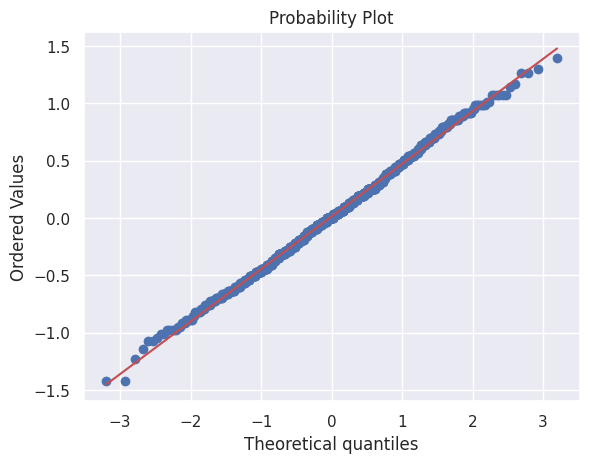

In [ ]:
_ = sps.probplot(P, dist=sps.norm(loc=0, scale=1), plot=plt)

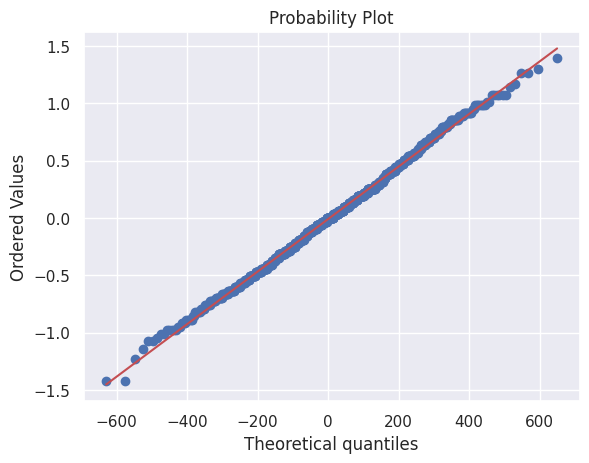

In [ ]:
_ = sps.probplot(P, dist=sps.norm(loc=10, scale=200), plot=plt)

Как вы можете наблюдать, QQ-plot успешно игнорирует параметры сдвига и масштаба для плотности. Попробуйте самостоятельно доказать, как ведут себя точки при изменении параметров сдвига и масштаба.

Посмотрим, что бы было, если бы мы угадали семейство распределения неверно (и получить истинную плотность из предположенной при помощи изменения параметров сдвига и масштаба невозможно)

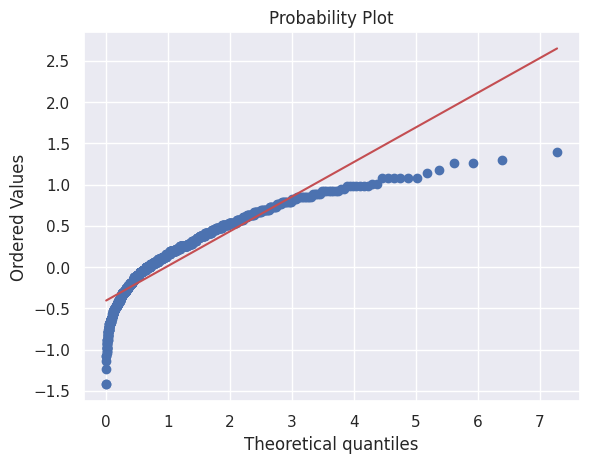

In [ ]:
_ = sps.probplot(P, dist=sps.expon(loc=0, scale=1), plot=plt)

На самом деле, по форме QQ-plot можно делать выводы о том, тяжелее ли хвосты эмпирического распределения, чем хвосты предложенного теоретического или нет. Как именно делать такие выводы --- задача в домашней работе.

Заметим, что пока мы ещё не проверили сходимости по распределению, а проверили только похожесть на некотором $n$. Для эмпирической проверки сходимости необходимо построить несколько графиков для растущих $n$ и проверить, что они приближаются к истинному.

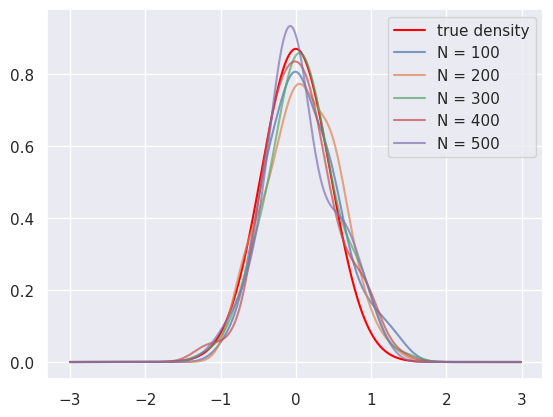

In [ ]:
N = 100
X = sps.bernoulli.rvs(p=0.3, size=(N, N))
P = np.sqrt(np.arange(1, N+1))*(np.cumsum(X, axis=1)/np.arange(1, N+1) - mu)
grid = np.arange(-3, 3, 1e-2)
plt.plot(grid, sps.norm.pdf(grid, scale=sigma, loc=0), label='true density', color='red')
for i in range(1, 6):
    kernel = sps.gaussian_kde(P[:,20*i-1])
    plt.plot(grid, kernel(grid), label='N = '+str(100*i), alpha=0.7)
plt.legend()

Из-за отсутствия монотонности сходимости, на таком графике сложно отследить поведение функции, но виден эффект концентрации --- плотности стремятся к своему пределу. Посмотрим, насколько быстро.

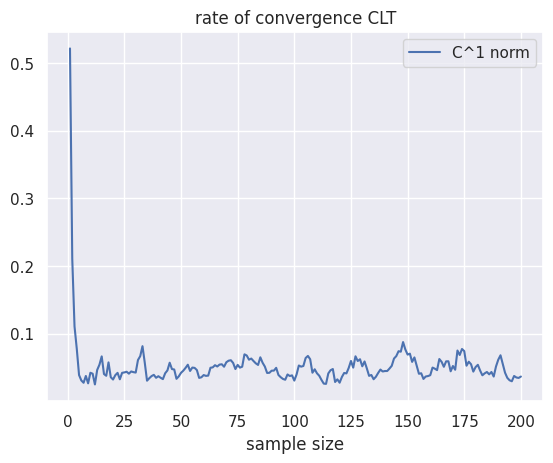

In [ ]:
N = 1000
X = sps.bernoulli.rvs(p=0.3, size=(N, N))
P = np.sqrt(np.arange(1, N+1))*(np.cumsum(X, axis=1)/np.arange(1, N+1) - mu)

errors = []
for i in range(1, 201):
    kernel = sps.gaussian_kde(P[:,5*i-1])
    errors.append(abs(max(kernel(grid) - sps.norm.pdf(grid, scale=sigma, loc=0))))
plt.title('rate of convergence CLT')
plt.plot(np.arange(1, 201), errors, label='C^1 norm')
plt.xlabel('sample size')
plt.legend()

Сходимость наблюдается, но очень медленная. Более точные оценки скорости ЦПТ были в курсе теории вероятности. Попробуйте проверить их эмпирически.